In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml

In [3]:
predictions_dict = {}

In [4]:
config_filename = 'jharkhand.yaml'
config = read_config(config_filename)

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
pulling from source
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 142                 | 143                 | 144                 | 145                 | 146                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-16 00:00:00 | 2020-09-17 00:00:00 | 2020-09-18 00:00:00 | 2020-09-19 00:00:00 | 2020-09-20 00:00:00 |
| state       | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           |
| district    | Ranchi              | Ranchi              | Ranchi              | Ranchi              | Ranchi              |
| total       | 14210.0             | 14569.29            | 14955.0             | 15239.0             | 15707.0             |
| active      | 3242.71           

/home/ramkamal/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


100%|██████████| 1000/1000 [01:17<00:00, 12.93trial/s, best loss: 1.354291230917058]
best parameters
 {'E_hosp_ratio': 0.06005152817891994, 'I_hosp_ratio': 0.44342662907163904, 'P_fatal': 0.006763424741414021, 'T_inc': 4.88671029094999, 'T_inf': 3.2472793262799278, 'T_recov': 8.723423401402808, 'T_recov_fatal': 10.132743681539512, 'lockdown_R0': 1.3819380929454872}
Performing m2 fit ..
loading from ../../misc/cache/dataframes_ts_25092020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 145                 | 146                 | 147                 | 148                 | 149                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-19 00:00:00 | 2020-09-20 00:00:00 | 2020-09-21 00:00:00 | 2020-09-22 00:00:00 | 2020-09-23 00:00:00 |

/home/ramkamal/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


 23%|██▎       | 232/1000 [00:13<00:49, 15.38trial/s, best loss: 2.4131950030503124]

/home/ramkamal/anaconda3/envs/covid/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:337: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]

/home/ramkamal/anaconda3/envs/covid/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:359: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE



100%|██████████| 1000/1000 [01:14<00:00, 13.47trial/s, best loss: 1.649494433091176]
best parameters
 {'E_hosp_ratio': 0.446726572010717, 'I_hosp_ratio': 0.2625032881612391, 'P_fatal': 0.015366892819307948, 'T_inc': 4.582308431783419, 'T_inf': 3.7772621294321103, 'T_recov': 8.87024890529488, 'T_recov_fatal': 38.30154396379727, 'lockdown_R0': 1.402931513195186}


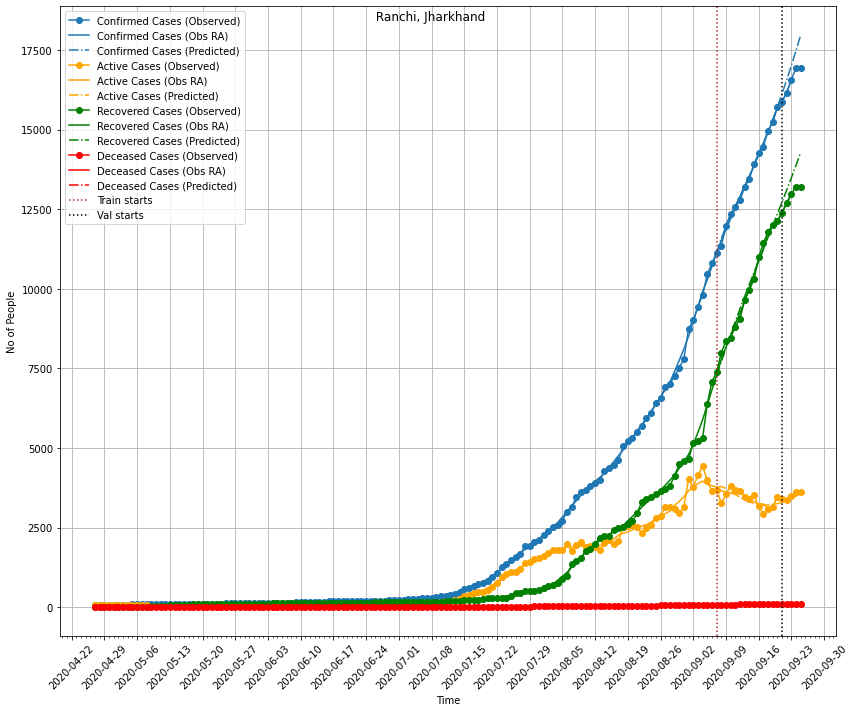

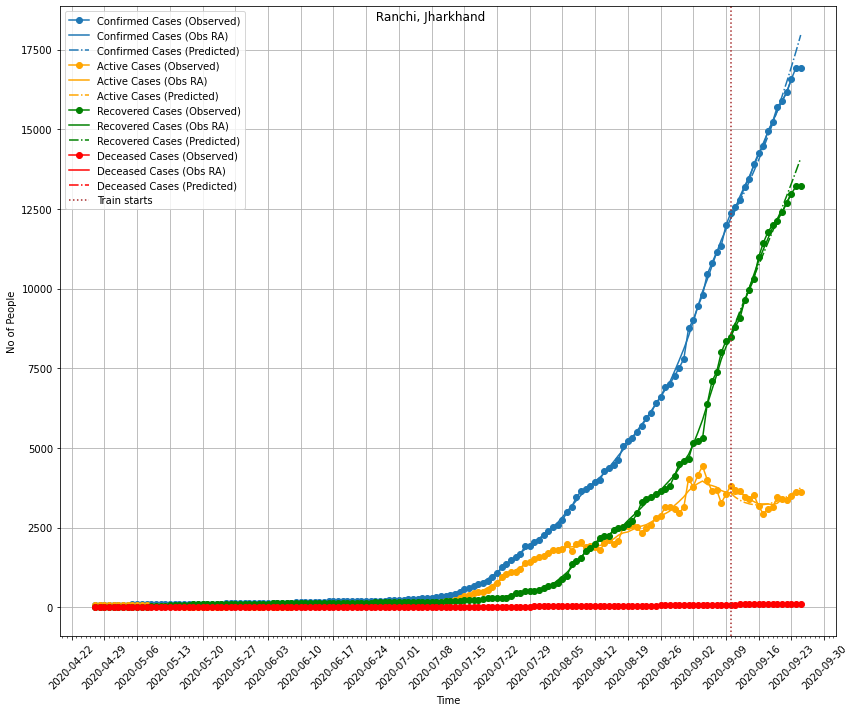

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [7]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.06005152817891994,
 'I_hosp_ratio': 0.44342662907163904,
 'P_fatal': 0.006763424741414021,
 'T_inc': 4.88671029094999,
 'T_inf': 3.2472793262799278,
 'T_recov': 8.723423401402808,
 'T_recov_fatal': 10.132743681539512,
 'lockdown_R0': 1.3819380929454872}

In [8]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.446726572010717,
 'I_hosp_ratio': 0.2625032881612391,
 'P_fatal': 0.015366892819307948,
 'T_inc': 4.582308431783419,
 'T_inf': 3.7772621294321103,
 'T_recov': 8.87024890529488,
 'T_recov_fatal': 38.30154396379727,
 'lockdown_R0': 1.402931513195186}

## Loss Dataframes

### M1 Loss DataFrame

In [9]:
predictions_dict['m1']['df_loss']

,train,val
total,0.510289,2.22422
active,5.29322,1.77857
recovered,1.77221,3.25045
deceased,2.24427,8.8753


### M2 Loss DataFrame

In [10]:
predictions_dict['m2']['df_loss']

,train
total,1.10273
active,4.86046
recovered,1.54346
deceased,2.45935


## Sensitivity Plot

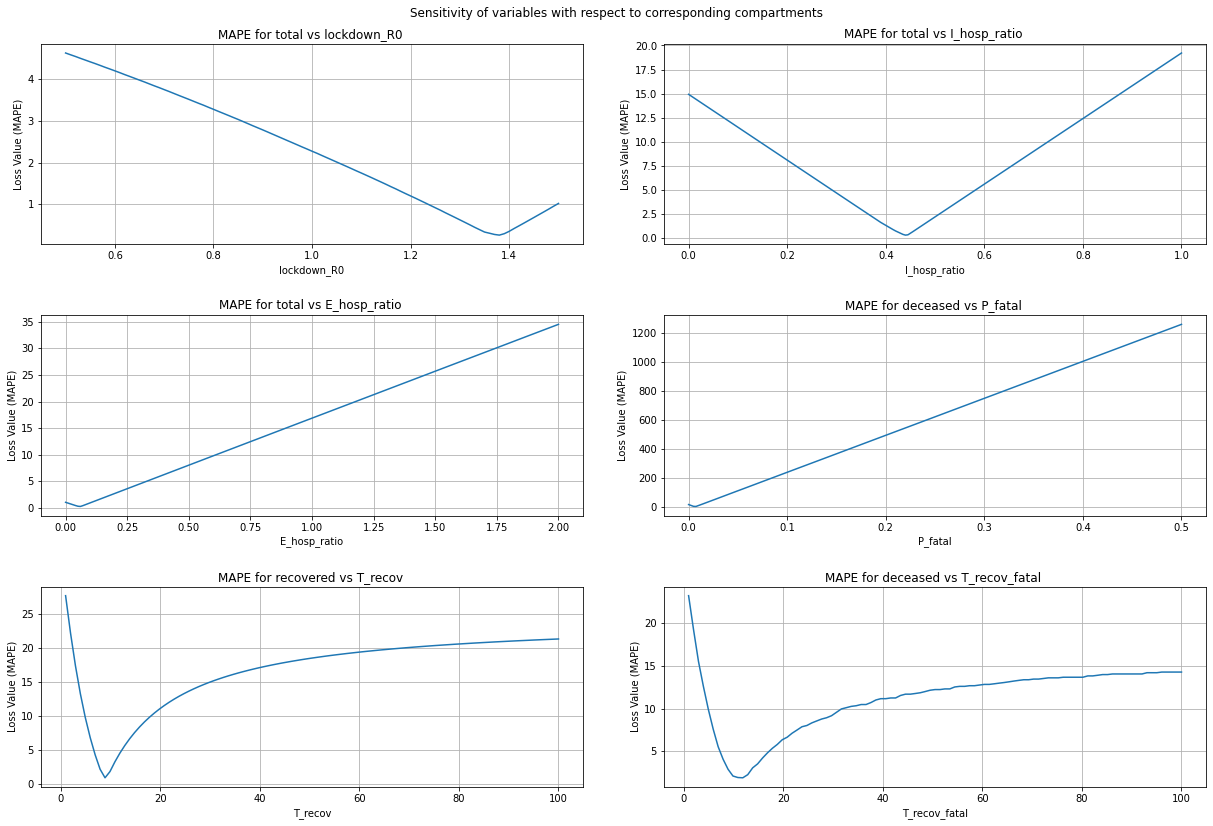

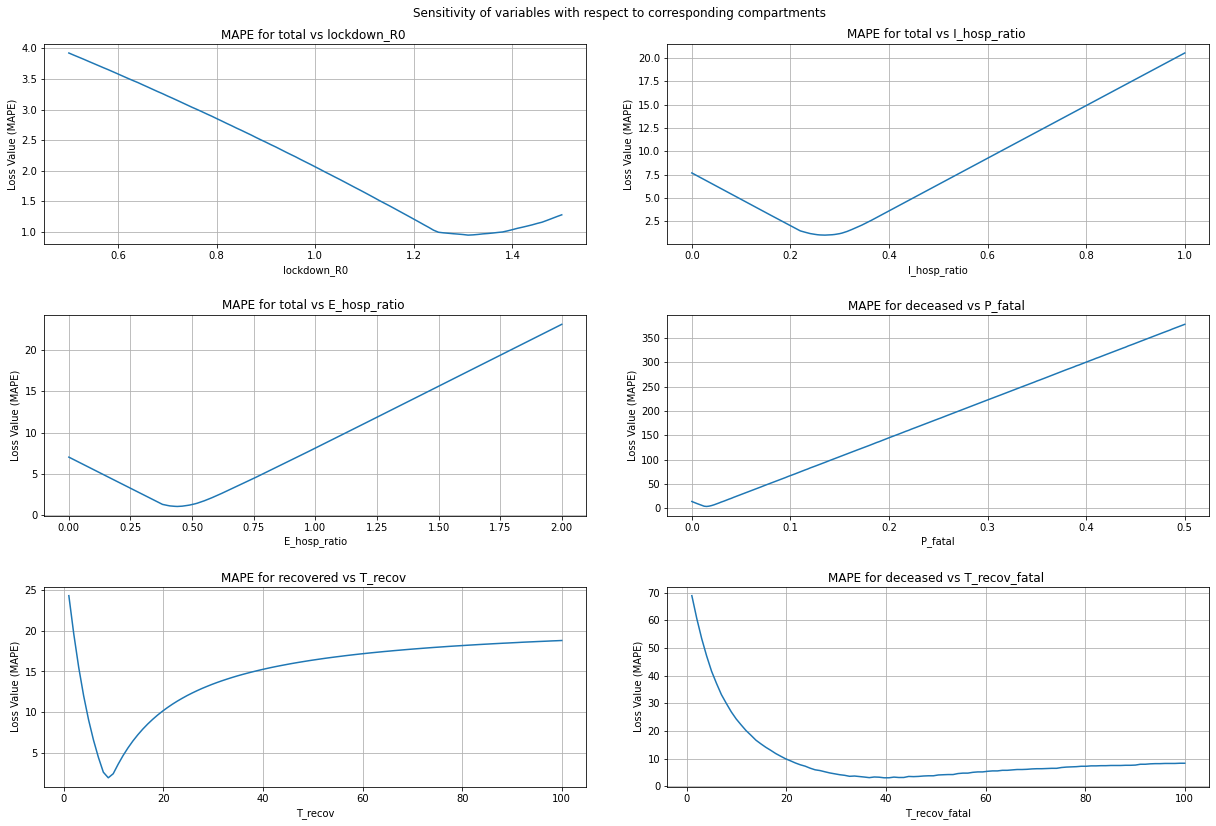

In [11]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

getting forecasts ..


6it [00:00, 59.36it/s]

getting forecasts ..


1000it [00:19, 51.44it/s]
6it [00:00, 59.73it/s]

getting forecasts ..


703it [00:12, 52.97it/s]/home/ramkamal/anaconda3/envs/covid/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:337: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/ramkamal/anaconda3/envs/covid/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:359: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
1000it [00:20, 49.34it/s]


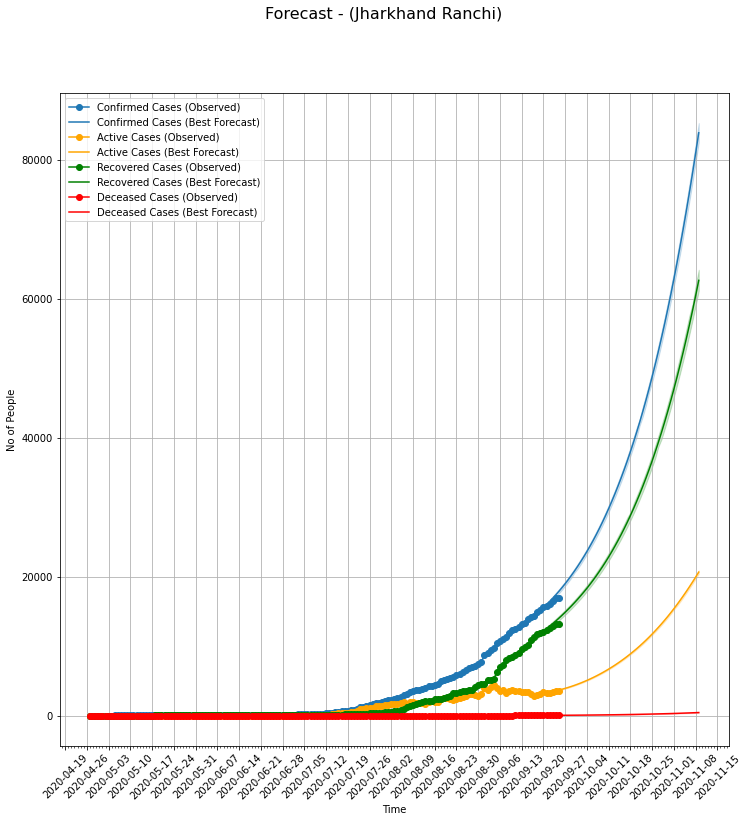

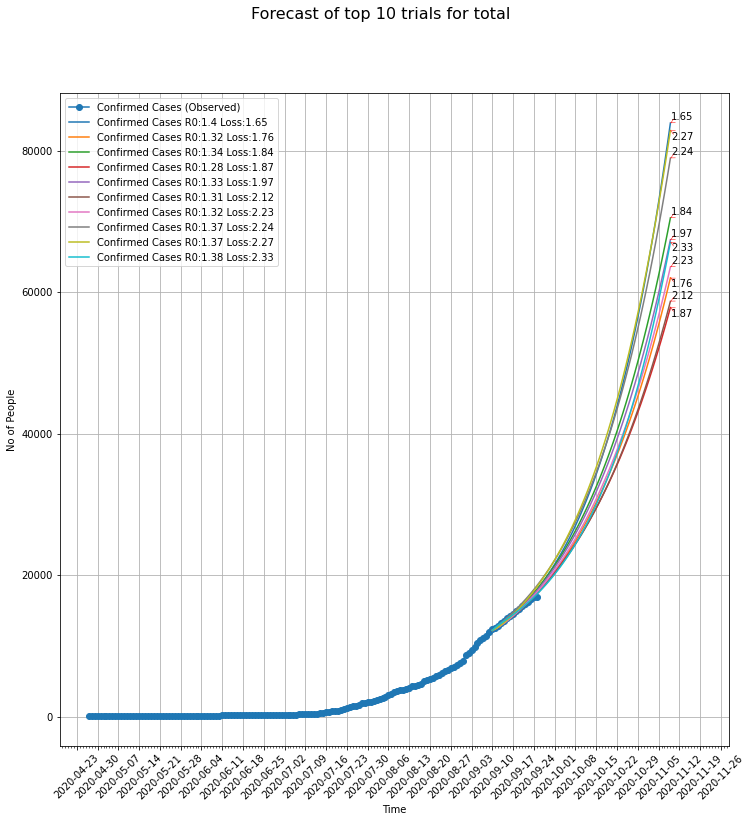

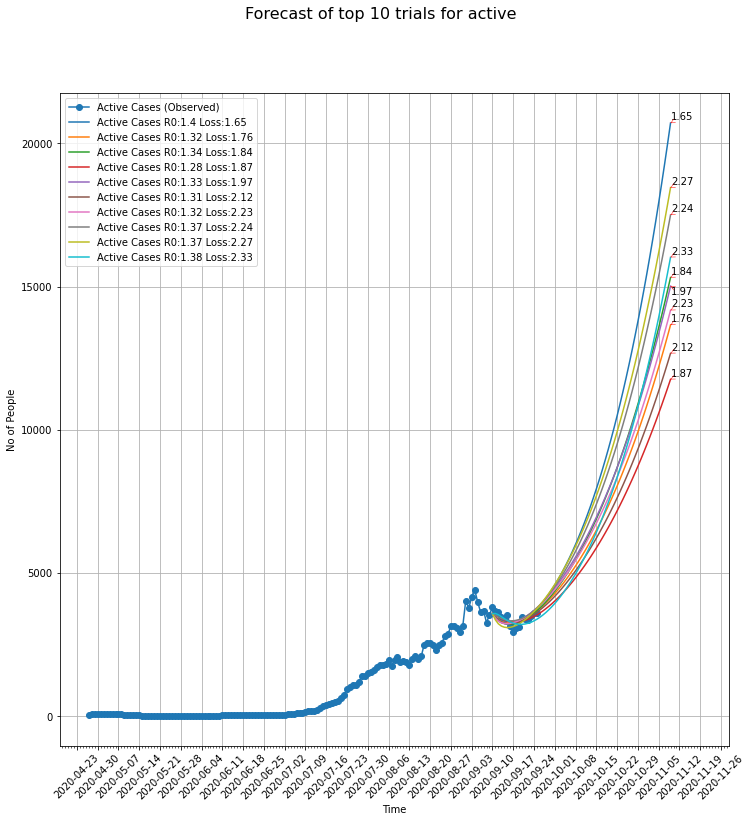

In [12]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [13]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [01:07<00:00,  1.48trial/s, best loss: 4.029473580889727]


In [14]:
uncertainty.beta_loss

{'active': 1.5870303923997977,
 'recovered': 3.148266285938991,
 'deceased': 9.196007724522765,
 'total': 2.1865899206973523}

In [15]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [16]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

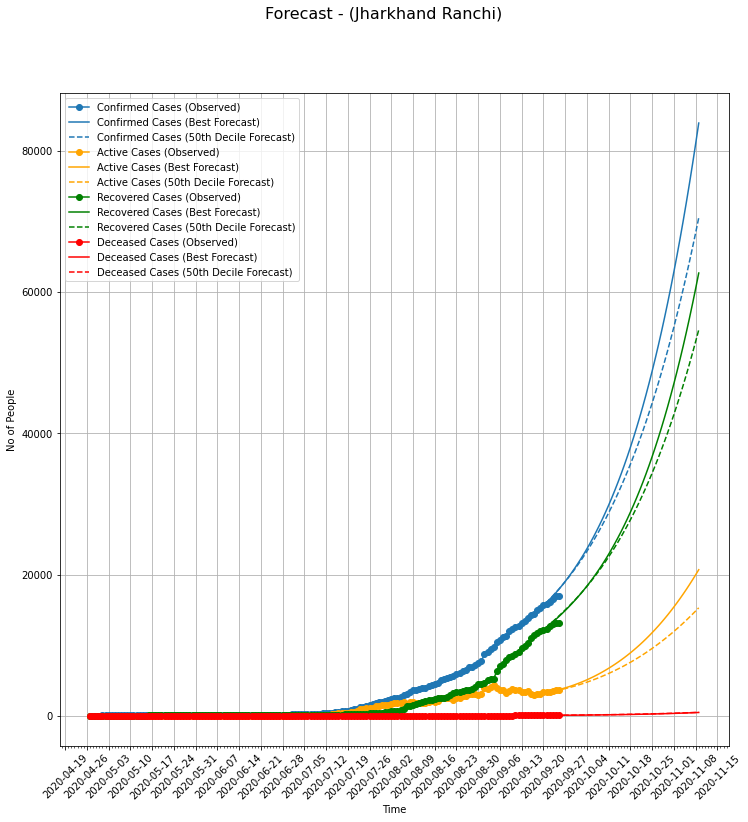

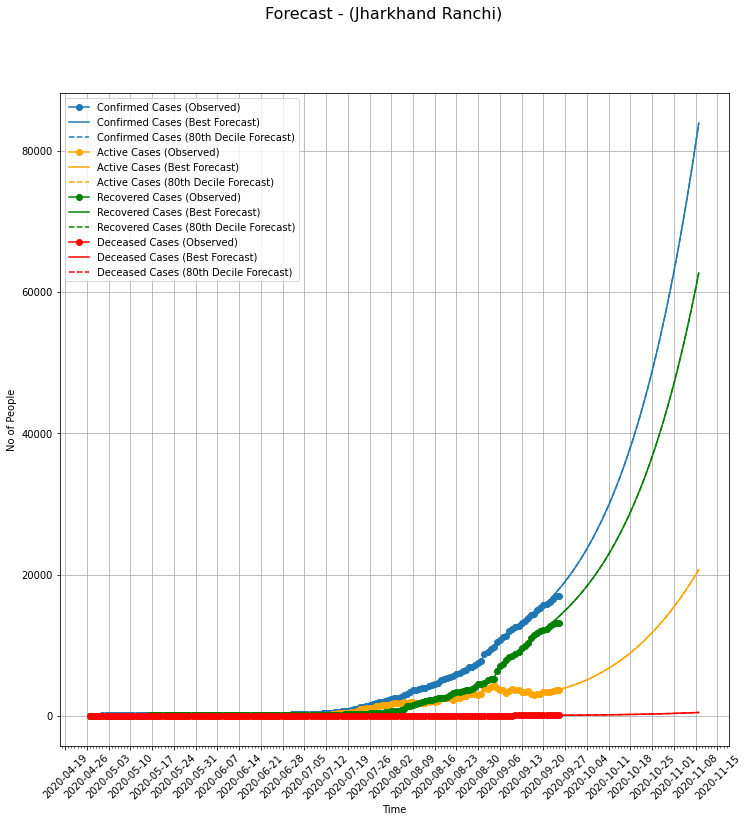

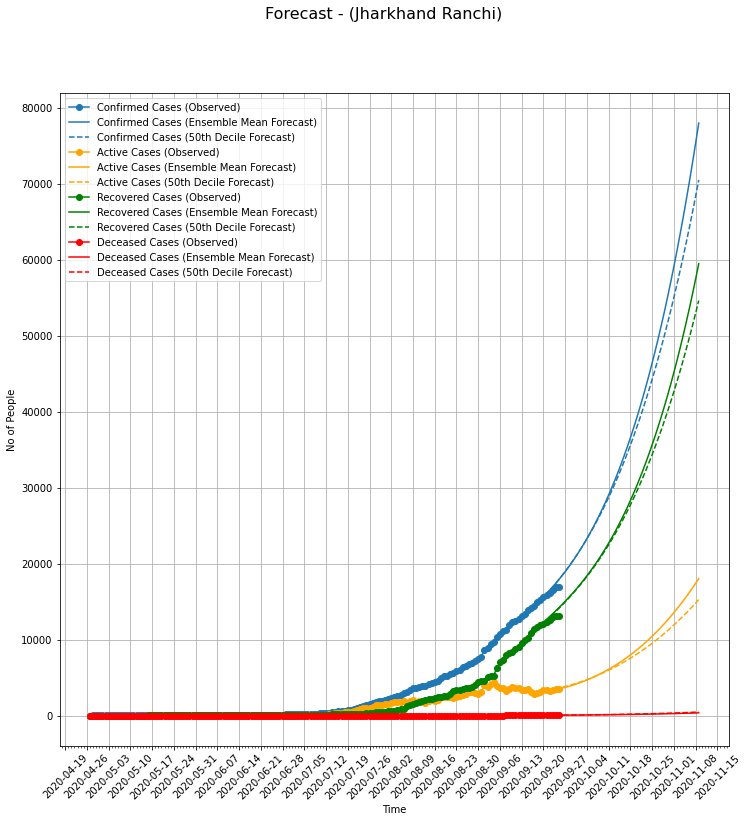

In [17]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

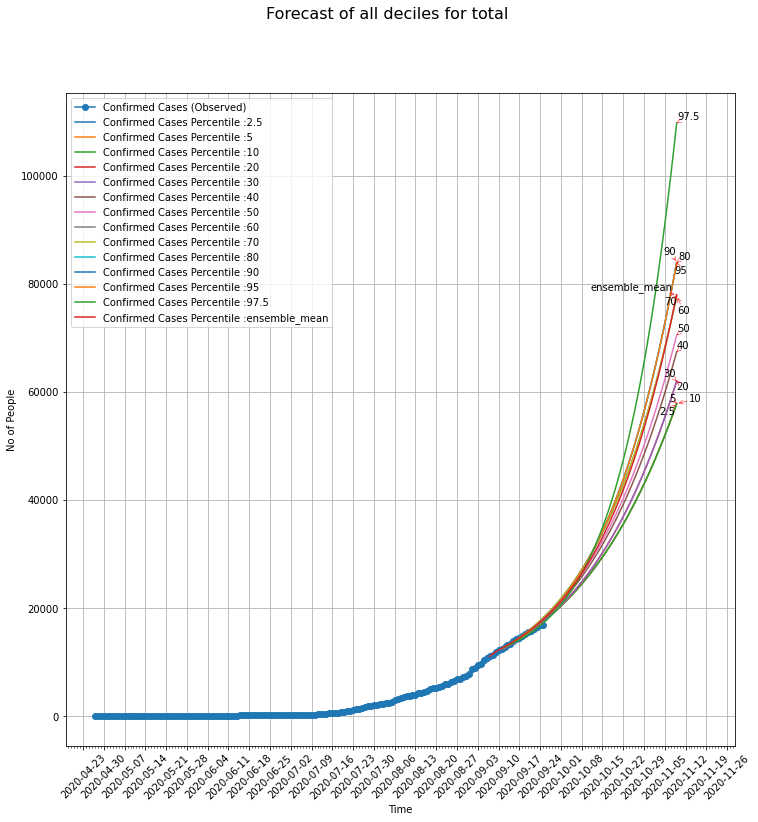

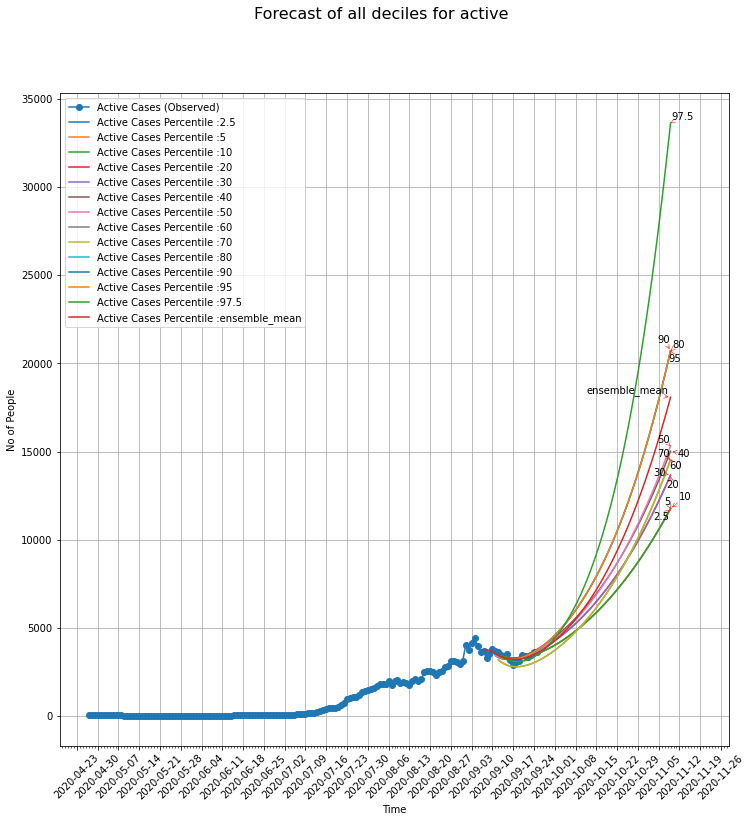

In [18]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [19]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [20]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [21]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [22]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Experiments

In [23]:
predictions_dict['m1'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'df_district_unsmoothed', 'run_params', 'trials_processed'])